In [2]:
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from gridworld.simulation import simulate_episode
from gridworld.agent import Agent, LoggerAgent, SweeperAgent
from gridworld.tile_types import TileType
from gridworld.world import World, LoggerTrainingWorld
from gridworld.exploration import ExplorationMethod, EpsilonGreedy

from models.ann import DeepQNet
from models.utils import ReplayMemory

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: ', device)
print('Torch: ', torch.__version__)

NUM_EPOCHS: int = 100
EPISODE_DURATION: int = 64
NUM_EPISODES_PER_EPOCH: int = 64
BATCH_SIZE: int = 32

DISCOUNT_FACTOR = 0.97
LEARNING_RATE = 1e-4
#RANDOM_EXPLORATION_DECAY = 0.95
MAX_EXPLORE_PROBABILITY = 1.0
MIN_EXPLORE_PROBABILITY = 0.2
WEIGHT_DECAY = 0

world_instances = {
    TileType.tree.value: 10,
    TileType.log.value: 0
}
world: World = LoggerTrainingWorld(grid_size=5, instances=world_instances)

agents: list[Agent] = [LoggerAgent()]#, SweeperAgent()]
policies = [DeepQNet(agent).to(device) for agent in agents]

# Load models
load_model_name = None#'2023-07-19_16-36'
for policy, agent in zip(policies, agents):
    if not load_model_name is None:
        policy.load_state_dict(torch.load(f'output/{load_model_name}/policy_{agent.name}.pth'))
    policy = policy.to(device)

loss_fns = [nn.MSELoss() for _ in agents]
optimizers = [torch.optim.Adam(policy.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY) for policy in policies]
#torch.compile(policy) # Not supported in python 3.11

loss_histories = [[] for _ in agents]
exploration_methods: list[ExplorationMethod] = [EpsilonGreedy(agent, world, device, epsilon = 1.0) for agent in agents]
for epoch in tqdm(range(NUM_EPOCHS), desc="Epochs"):
    running_losses = [0.0 for _ in agents]
    for i, (agent, policy, optimizer, exploration_method, loss_fn) in enumerate(zip(agents, policies, optimizers, exploration_methods, loss_fns)):
       
        # Polulate the replay memory by simulating episodes
        memories = ReplayMemory(agent, device)
        for episode in range(NUM_EPISODES_PER_EPOCH):
            world = LoggerTrainingWorld()
            observations, actions, inventories, rewards, duration = simulate_episode(agent, world, policy, exploration_method, device, EPISODE_DURATION)
            memories.add_experience(observations, actions, inventories, rewards, discount_factor=DISCOUNT_FACTOR)

        # Train the policy on the replay memory
        episode_batches = memories.get_all_batches(BATCH_SIZE)
        for (observations, actions, inventories, rewards) in episode_batches:
            optimizer.zero_grad()
            
            # Compute the predicted rewards
            predicted_rewards = policy(observations, inventories)
            predicted_rewards_of_actions = torch.gather(predicted_rewards, dim=1, index=actions.long())
            
            # Compute the loss
            loss = loss_fn(predicted_rewards_of_actions, rewards)
            loss.backward()
            optimizer.step()
            running_losses[i] += loss.item()
        
        # Record the running loss
        num_batches = len(memories.observations) // BATCH_SIZE
        loss_histories[i].append(running_losses[i] / num_batches)
    
    # Decay the exploration rate
    for exp in exploration_methods:
        if isinstance(exp, EpsilonGreedy):
            exp.epsilon = MIN_EXPLORE_PROBABILITY + (MAX_EXPLORE_PROBABILITY - MIN_EXPLORE_PROBABILITY) * epoch / NUM_EPOCHS

Device:  cuda
Torch:  2.0.1+cu117


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import datetime
import os

timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
save_dir = ''
if load_model_name is None:
    save_dir = timestamp
    os.mkdir(f"output/{save_dir}")
else:
    save_dir = load_model_name
    
for i, policy in enumerate(policies):
    filename = f"output/{save_dir}/policy_{agents[i].name}.pth"
    torch.save(policy.state_dict(), filename)

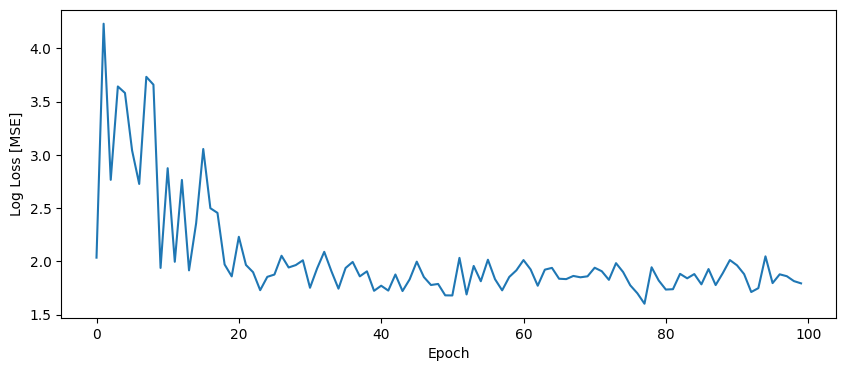

In [ ]:
import matplotlib.pyplot as plt
if len(agents) > 1:
    fig, axs = plt.subplots(nrows=len(agents), ncols=1, figsize=(10, 10))
    for i, loss in enumerate(loss_histories):
        axs[i].plot(torch.log(torch.tensor(loss)))
        axs[i].set_xlabel('Epoch')
        axs[i].sey_ylabel('Log Loss [MSE]')
else:
    fig = plt.figure(figsize=(10, 4))
    plt.plot(torch.log(torch.tensor(loss_histories[0])))
    plt.xlabel('Epoch')
    plt.ylabel('Log Loss [MSE]')